This kernel is copied and modified bases on: https://www.kaggle.com/omarelgabry/a-journey-through-titanic#131541

I walked through the whole process and learned the ML / analysis ideas from it. Then try finding some improvements to make the prediction better.

Decision Tree: 0.77
Random Forest: 0.75

In [95]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
#https://seaborn.pydata.org/tutorial/aesthetics.html
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from matplotlib.gridspec import GridSpec # refer to http://matplotlib.org/examples/pylab_examples/pie_demo2.html

In [96]:
#load dataset
titanic_df = pd.read_csv("train.csv")
test_df    = pd.read_csv("test.csv")

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [97]:
titanic_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [98]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
#titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
#test_df    = test_df.drop(['Name','Ticket'], axis=1)
# do dropping process before training

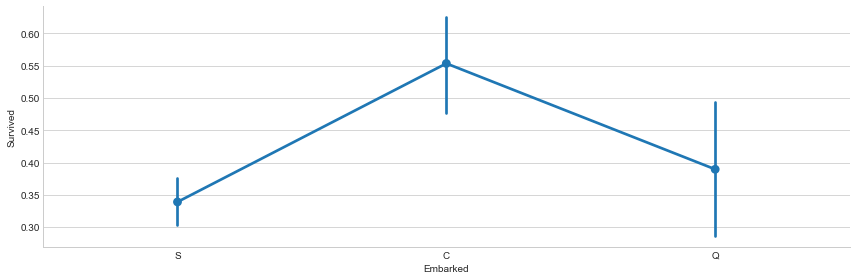

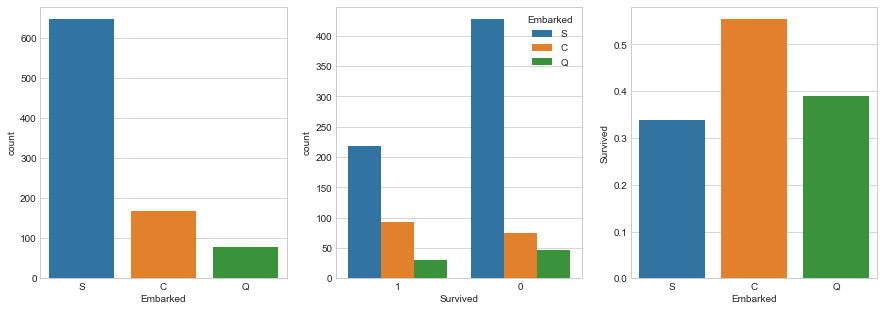

In [99]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S". 
# only 2 passengers without embarked info, should be ok
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)
#https://seaborn.pydata.org/generated/seaborn.factorplot.html

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=titanic_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=titanic_df,kind='count',order=[1,0],ax=axis2)
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

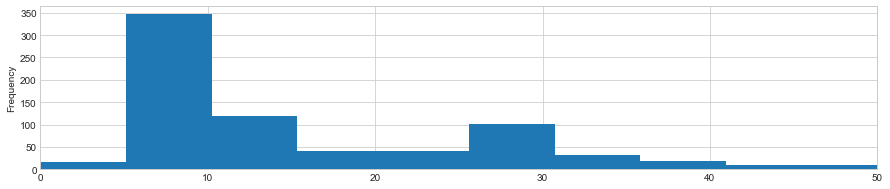

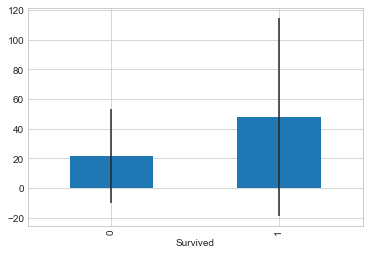

In [100]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)
#blue bar represents the mean, black line represents the errorbar (+1 std and -1 std)

In [101]:
#The fare range is pretty diverse, how about categorizing the range and compare? #maybe not necessary


/Users/KunWuYao/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


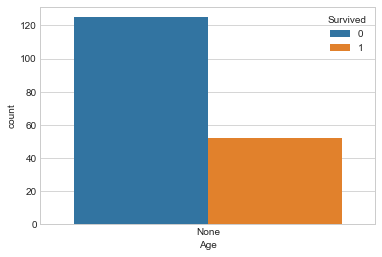

In [102]:
# before filling age info into the dataset, I wanna know how many ppl with NaN values in Age survived
count_nan_age_titanic = titanic_df[titanic_df["Age"].isnull()]
count_nan_age_titanic.loc[:, ['Age']] = "None"
count_nan_age_titanic.head()
sns.countplot(x = 'Age', hue = 'Survived', data = count_nan_age_titanic)

In [103]:
#print(count_nan_age_titanic, count_nan_age_test)
#so many NaN values...

In [104]:
# Age 

# Maybe try grouping age instead

#fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
#axis1.set_title('Original Age values - Titanic')
#axis2.set_title('New Age values - Titanic')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

# get average, std, and number of NaN values in titanic_df
#average_age_titanic   = titanic_df["Age"].mean()
#std_age_titanic       = titanic_df["Age"].std()
#count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
#average_age_test   = test_df["Age"].mean()
#std_age_test       = test_df["Age"].std()
#count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
#rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
#rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
#titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
#titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
#test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
#titanic_df['Age'] = titanic_df['Age'].astype(int)
#test_df['Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
#titanic_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

In [105]:
# How can you determine that passengers with NaN age info might have been all in the range of median +- one std?
#Code for Q2
categories = ['Baby', 'Child','Teenager','Adult','Elder','Unknown']
def survivor_counter(self):
    for i in self['Age']:
        if i <= 5:
            self['Category'] = categories[0]
        elif i <= 12:
            self['Category'] = categories[1]
        elif i <= 18:
            self['Category'] = categories[2]
        elif i <= 65:
            self['Category'] = categories[3]
        elif i <= 80:
            self['Category'] = categories[4]
        else:
            self['Category'] = categories[5]
    return self

age_filter = titanic_df.groupby('PassengerId')[['Survived', 'Age']].apply(survivor_counter)
#reference http://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas

#calculate survival percentage, first count total numbers for every category.
age_counter = [len(age_filter[(age_filter.Category == categories[0])]), 
                   len(age_filter[(age_filter.Category == categories[1])]), 
                   len(age_filter[(age_filter.Category == categories[2])]),
                   len(age_filter[(age_filter.Category == categories[3])]),
                   len(age_filter[(age_filter.Category == categories[4])]),
              len(age_filter[(age_filter.Category == categories[5])])]
print(age_counter)
age_survival_count = []
age_survival_rate = []
for i in range(0,6):
    age_survival_count.append(age_filter[(age_filter.Category == categories[i])]['Survived'].sum())
    age_survival_rate.append(age_survival_count[i]/age_counter[i])
print(age_survival_count, age_survival_rate)

[44, 25, 70, 567, 8, 177]
[31, 9, 30, 219, 1, 52] [0.7045454545454546, 0.36, 0.42857142857142855, 0.3862433862433862, 0.125, 0.2937853107344633]


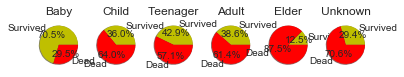

In [106]:
#Plot for Q2
sur_labels = ['Survived', 'Dead']
the_grid = GridSpec(1,6)
for i in range(0,6):
    plt.subplot(the_grid[0, i], aspect = 1)
    plt.pie([age_survival_rate[i], (1-age_survival_rate[i])], labels=sur_labels, autopct='%1.1f%%', colors = ['y','r'], shadow = True)
    plt.title('%s' % (categories[i]))
plt.show()

In [107]:
titanic_df = titanic_df.groupby('PassengerId').apply(survivor_counter)
test_df = test_df.groupby('PassengerId').apply(survivor_counter)

In [110]:
# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
age_dummies_titanic  = pd.get_dummies(titanic_df['Category'])
age_dummies_titanic.columns = ['Adult', 'Baby', 'Child', 'Elder','Teenager','Unknown'] #much follow the alphabet order
age_dummies_titanic.drop(['Unknown'], axis=1, inplace=True)
# why implement get_dummies???
# http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/
# one-hot encoding (categorization)

age_dummies_test  = pd.get_dummies(test_df['Category'])
age_dummies_test.columns = ['Adult', 'Baby', 'Child', 'Elder','Teenager','Unknown']
age_dummies_test.drop(['Unknown'], axis=1, inplace=True)
#titanic_df.drop(['Adult', 'Baby', 'Child', 'Elder','Teenager','Unknown'], axis = 1, inplace = True)
#test_df.drop(['Adult', 'Baby', 'Child', 'Elder','Teenager','Unknown'], axis = 1, inplace = True)
titanic_df = titanic_df.join(age_dummies_titanic)
test_df    = test_df.join(age_dummies_test)

In [111]:
#drop Category and Age
titanic_df = titanic_df.drop(['Category'], axis = 1)
test_df = test_df.drop(['Category'], axis = 1)

In [112]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
#facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
#aspect means ratio related to size (size * aspect = fig size)
#facet.map(sns.kdeplot,'Age',shade= True)
#kdeplot => show data density
#facet.set(xlim=(0, titanic_df['Age'].max()))
#facet.add_legend()

# average survived passengers by age
#fig, axis1 = plt.subplots(1,1,figsize=(18,4))
#average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
#sns.barplot(x='Age', y='Survived', data=average_age)

#not usful

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


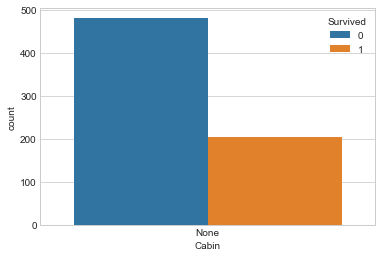

In [113]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
#titanic_df.drop("Cabin",axis=1,inplace=True)
#test_df.drop("Cabin",axis=1,inplace=True)

#should investgate before dropping directly
count_nan_cabin_titanic = titanic_df[titanic_df["Cabin"].isnull()]
count_nan_cabin_titanic.loc[:, ['Cabin']] = "None"
count_nan_cabin_titanic.head()
sns.countplot(x = 'Cabin', hue = 'Survived', data = count_nan_cabin_titanic)

In [114]:
#looks like passengers without cabin info have higher changce to die, how about passengers with cabin info?
titanic_df.loc[titanic_df["Cabin"].isnull(), ['Cabin']] = 0
titanic_df.loc[titanic_df["Cabin"] != 0, ['Cabin']] = 1
test_df.loc[test_df["Cabin"].isnull(), ['Cabin']] = 0
test_df.loc[test_df["Cabin"] != 0, ['Cabin']] = 1
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,Adult,Baby,Child,Elder,Teenager
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7,0,0,1,1,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7,0,0,0,1,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9,0,0,1,1,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8,0,0,0,1,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12,0,0,0,1,0,0,0,0


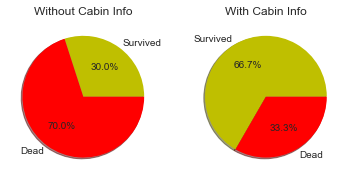

In [115]:
count_nan_cabin_titanic = titanic_df[(titanic_df["Cabin"] == 0)]
count_nan_cabin_survival = count_nan_cabin_titanic['Survived'].sum()
count_cabin_titanic = titanic_df[(titanic_df["Cabin"] != 0)]
count_cabin_survival = count_cabin_titanic['Survived'].sum()
# Compare the suvival
sur_labels = ['Survived', 'Dead']
the_grid = GridSpec(1,2)
plt.subplot(the_grid[0, 0], aspect = 1)
plt.pie([count_nan_cabin_survival/len(count_nan_cabin_titanic), (1-count_nan_cabin_survival/len(count_nan_cabin_titanic))], labels=sur_labels, autopct='%1.1f%%', colors = ['y','r'], shadow = True)
plt.title('Without Cabin Info')
plt.subplot(the_grid[0, 1], aspect = 1)
plt.pie([count_cabin_survival/len(count_cabin_titanic), (1-count_cabin_survival/len(count_cabin_titanic))], labels=sur_labels, autopct='%1.1f%%', colors = ['y','r'], shadow = True)
plt.title('With Cabin Info')

plt.show()
# Huge Diff!!!

/Users/KunWuYao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/KunWuYao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[<matplotlib.text.Text at 0x11563c198>, <matplotlib.text.Text at 0x1154c1550>]

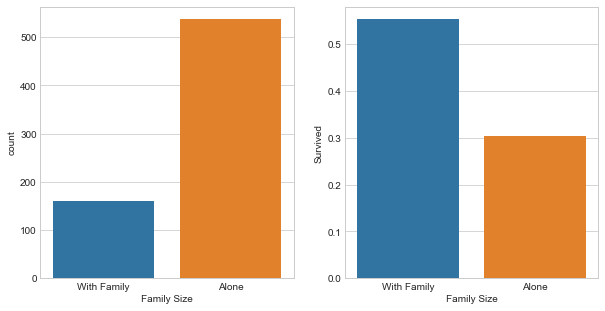

In [117]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
titanic_df['Family Size'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df['Alone'] = 0
titanic_df['Alone'][titanic_df['Family Size'] == 0] = 1

test_df['Family Size'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Alone'] = 0
test_df['Alone'][test_df['Family Size'] == 0] = 1

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Family Size', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = titanic_df[["Family Size", "Survived"]].groupby(['Family Size'],as_index=False).mean()
sns.barplot(x='Family Size', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

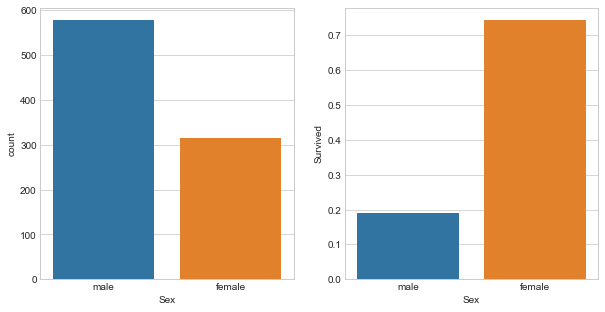

In [118]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
# That is unnecessary

#def get_person(passenger):
#    age,sex = passenger
#    return 'child' if age < 5 else sex
    
#titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
#test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
#titanic_df.drop(['Sex'],axis=1,inplace=True)
#test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
sex_dummies_titanic  = pd.get_dummies(titanic_df['Sex'])
sex_dummies_titanic.columns = ['Female','Male']
sex_dummies_titanic.drop(['Male'], axis=1, inplace=True)
# why implement get_dummies???
# http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/
# one-hot encoding (categorization)

sex_dummies_test  = pd.get_dummies(test_df['Sex'])
sex_dummies_test.columns = ['Female','Male']
sex_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(sex_dummies_titanic)
test_df    = test_df.join(sex_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Sex', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean()
sns.barplot(x='Sex', y='Survived', data=person_perc, ax=axis2, order=['male','female'])

titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

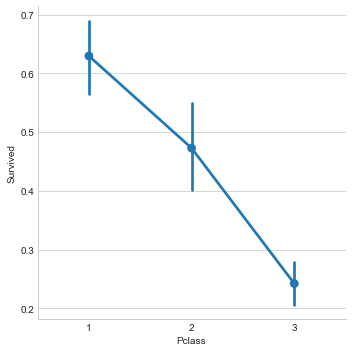

In [119]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [120]:
#recheck the dataset and determine dropping unused items
titanic_df.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Cabin,C,Q,Adult,Baby,Child,Elder,Teenager,Family Size,Alone,Female,Class_1,Class_2
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7,0,0,0,1,0,0,0,0,1,0,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71,1,1,0,1,0,0,0,0,1,0,1,1,0
2,3,1,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7,0,0,0,1,0,0,0,0,0,1,1,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53,1,0,0,1,0,0,0,0,1,0,1,1,0
4,5,0,"Allen, Mr. William Henry",35.0,373450,8,0,0,0,1,0,0,0,0,0,1,0,0,0


In [121]:
test_df.head()

,PassengerId,Name,Age,Ticket,Fare,Cabin,C,Q,Adult,Baby,Child,Elder,Teenager,Family Size,Alone,Female,Class_1,Class_2
0,892,"Kelly, Mr. James",34.5,330911,7,0,0,1,1,0,0,0,0,0,1,0,0,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,363272,7,0,0,0,1,0,0,0,0,1,0,1,0,0
2,894,"Myles, Mr. Thomas Francis",62.0,240276,9,0,0,1,1,0,0,0,0,0,1,0,0,1
3,895,"Wirz, Mr. Albert",27.0,315154,8,0,0,0,1,0,0,0,0,0,1,0,0,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,3101298,12,0,0,0,1,0,0,0,0,2,0,1,0,0


In [122]:
# define training and testing sets

X_train = titanic_df.drop(["Survived", "PassengerId", "Name", "Ticket", "Age"],axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop(["PassengerId", "Name", "Ticket", "Age"],axis=1).copy()

In [123]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

0.81593714927048255

In [124]:
# Support Vector Machines

svc = SVC()

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)

svc.score(X_train, Y_train)

0.82379349046015715

In [134]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.92368125701459036

In [132]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)

0.86195286195286192

In [127]:
# Gaussian Naive Bayes

gaussian = GaussianNB()

gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

gaussian.score(X_train, Y_train)

0.77553310886644222

In [130]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
decision_tree.score(X_train, Y_train)

0.92368125701459036

In [129]:
# get Correlation Coefficient for each feature using Logistic Regression
#coeff_df = DataFrame(titanic_df.columns.delete(0))
#coeff_df.columns = ['Features']
#coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
#coeff_df

In [135]:
#applied Decision Tree
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)